C. elegans application - ciliated neurons
----
Preprocessing, merging annotations and plotting them on provided embeddings. 

This data comes from [Packer et al., Science 2019](https://science.sciencemag.org/content/365/6459/eaax1971). 

# Preliminaries

## Dependecy notebooks

This is the first of a series of notebooks. 

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [2]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scvelo as scv
import cellrank as cr
from cellrank._utils._colors import _convert_to_hex_colors

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3 

Global seed set to 0


## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [3]:
cr.logging.print_versions()

cellrank==1.5.2.dev206+ga2748bea scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2


In [4]:
cr.logging.print_version_and_date()

Running CellRank 1.5.2.dev206+ga2748bea, on 2023-07-17 16:11.


## Set up paths

In [5]:
sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

# adjust directories
DATA_DIR = DATA_DIR / "cytotrace_kernel" / "validation"
FIG_DIR = FIG_DIR / "cytotrace_kernel" / "validation"

scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Utility functions

In [6]:
def remap_colors(adata, key, color_map='gnuplot'):
    """Utlility to change the coloring """
    n_colors = len(adata.obs[key].cat.categories)
    adata.uns[f"{key}_colors"] = _convert_to_hex_colors(sns.color_palette(color_map, n_colors=n_colors))

## Set global parameters

Set some plotting parameters.

In [7]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

Set other global parameters

In [8]:
# should figures just be displayed or also saved?
save_figure = False

If there are other global parameters for this analysis, put them here as well. 

## Load the data

Import the data

In [9]:
adata = sc.read(DATA_DIR / "cytotrace_examples" / "Ciliated_neurons_celegans_matrix.txt").T
adata

AnnData object with n_obs × n_vars = 10775 × 20222

Import metadata

In [10]:
metadata = pd.read_csv(DATA_DIR / "cytotrace_examples" / "Ciliated_neurons_celegans_metadata.txt", sep='\t', skiprows=None, 
                       index_col=None)
print(metadata.shape)
metadata.head()

(10775, 5)


,Phenotype,Ground_truth,Component_1,Component_2,CytoTRACE
AAACCTGCAAGACGTG-300.1.1,ABalpppapav/ABpraaaapav,350,0.359376,1.359083,498
AAACCTGCATCACCCT-300.1.1,ABalapxpapa/ABpxpaaappa,380,1.295924,1.332611,537
AAACCTGGTGTGAATA-300.1.1,ABalppppa/ABpraaapa,190,0.712053,0.611391,936
AAACCTGTCGGCCGAT-300.1.1,ABpxpaaaaa,245,1.014098,0.776593,805
AAAGATGGTTCGTTGA-300.1.1,ABalaapppa/ABalapaapa,225,1.058949,0.819552,837


Import additional annotations on terminal cell types

In [11]:
terminal = pd.read_csv(DATA_DIR / "c_elegans" / "cedata-Ciliated neuronsdownmeta-2021-03-15.csv", skiprows=None, 
                       index_col=0)
print(terminal.shape)
terminal.head()

(10775, 14)


,n.umi,time.point,batch,Size_Factor,to.filter,cell.type,cell.subtype,plot.cell.type,raw.embryo.time,embryo.time,embryo.time.bin,raw.embryo.time.bin,lineage,Cluster
AAACCTGCAAGACGTG-300.1.1,1003,300_minutes,Waterston_300_minutes,0.606675,False,Ciliated_amphid_neuron,AFD,AFD,350,350,330-390,330-390,ABalpppapav/ABpraaaapav,19
AAACCTGCATCACCCT-300.1.1,1400,300_minutes,Waterston_300_minutes,0.846805,False,Ciliated_non_amphid_neuron,OLQ_parent,OLQ_parent,380,380,330-390,330-390,ABalapxpapa/ABpxpaaappa,42
AAACCTGGTGTGAATA-300.1.1,1458,300_minutes,Waterston_300_minutes,0.881887,False,Ciliated_amphid_neuron,unannotated,Ciliated_amphid_neuron,190,190,170-210,170-210,ABalppppa/ABpraaapa,22
AAACCTGTCGGCCGAT-300.1.1,1633,300_minutes,Waterston_300_minutes,0.987738,False,Ciliated_amphid_neuron,Neuroblast_AWC_SAAVx,Neuroblast_AWC_SAAVx,260,245,210-270,210-270,ABpxpaaaaa,6
AAAGATGGTTCGTTGA-300.1.1,1716,300_minutes,Waterston_300_minutes,1.037941,False,Ciliated_amphid_neuron,unannotated,Ciliated_amphid_neuron,220,225,210-270,210-270,ABalaapppa/ABalapaapa,6


## Merge annotations

Merge the study annotation

In [12]:
# join annotations
obs_updated = adata.obs.join(metadata, how='inner')

# restrict anndata to subset
adata = adata[obs_updated.index].copy()

# make sure the ordering of cells matches
assert((adata.obs_names == obs_updated.index).all()), "Annotation mismatch"

# copy new annotations into adata
adata.obs = obs_updated
adata

AnnData object with n_obs × n_vars = 10775 × 20222
    obs: 'Phenotype', 'Ground_truth', 'Component_1', 'Component_2', 'CytoTRACE'

Merge additional Cello annotations

In [13]:
# join annotations
obs_updated = adata.obs.join(terminal, how='inner')

# restrict anndata to subset
adata = adata[obs_updated.index].copy()

# make sure the ordering of cells matches
assert((adata.obs_names == obs_updated.index).all()), "Annotation mismatch"

# copy new annotations into adata
adata.obs = obs_updated
adata

AnnData object with n_obs × n_vars = 10775 × 20222
    obs: 'Phenotype', 'Ground_truth', 'Component_1', 'Component_2', 'CytoTRACE', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'to.filter', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'Cluster'

Make categorical

In [14]:
adata.obs['Phenotype'] = adata.obs['Phenotype'].astype('category')
adata.obs['cell.type'] = adata.obs['cell.type'].astype('category')
adata.obs['cell.subtype'] = adata.obs['cell.subtype'].astype('category')

Define a pseudotime based on the original CytoTrace score:

In [15]:
adata.obs['original_ct_pseudotime'] = 1 - adata.obs['CytoTRACE'].values / adata.obs['CytoTRACE'].values.max()

Get a numerical version of the ground truth for easier plotting:

In [16]:
adata.obs['Ground_truth_cont'] = adata.obs['Ground_truth'].astype(float).values.copy()

Make both ct ground truth a categorical, and change some color schemes. 

In [17]:
adata.obs['Ground_truth'] = adata.obs['Ground_truth'].astype('category')
remap_colors(adata, key='Ground_truth', color_map='gnuplot2')

Move embeddings to `.obsm`:

In [18]:
# cyto_trace = whatever they used
ct_embedding = np.concatenate((adata.obs['Component_1'].values[:, None],
                               adata.obs['Component_2'].values[:, None]),
                               axis=1)
adata.obsm['X_ct'] = ct_embedding

Work on the terminal state annotations

In [19]:
# make a copy
adata.obs['gt_terminal_states'] = adata.obs['cell.subtype'].copy()

# remove unannotated cells
mask = adata.obs['gt_terminal_states'] == 'unannotated'
adata.obs.loc[mask, 'gt_terminal_states'] = None

# remove parents and grandparents
for cat in adata.obs['gt_terminal_states'].cat.categories:
    if 'parent' in cat:
        print(f"Removing {cat}")
        mask = adata.obs['gt_terminal_states'] == cat
        adata.obs.loc[mask, 'gt_terminal_states'] = None 

Removing ADL_parent
Removing AIN_parent
Removing ASE_parent
Removing ASI_parent
Removing ASK_parent
Removing IL1_parent
Removing OLL_parent
Removing OLQ_grandparent
Removing OLQ_parent


Clean up annotations

In [20]:
scv.utils.cleanup(adata, clean=['obs'], 
                  keep=['Phenotype', 'Ground_truth', 'CytoTRACE', 'cell.type', 'cell.subtype', 'gt_terminal_states',
                        'original_ct_pseudotime', 'Ground_truth_cont'])

## Plot embeddings, check annotations

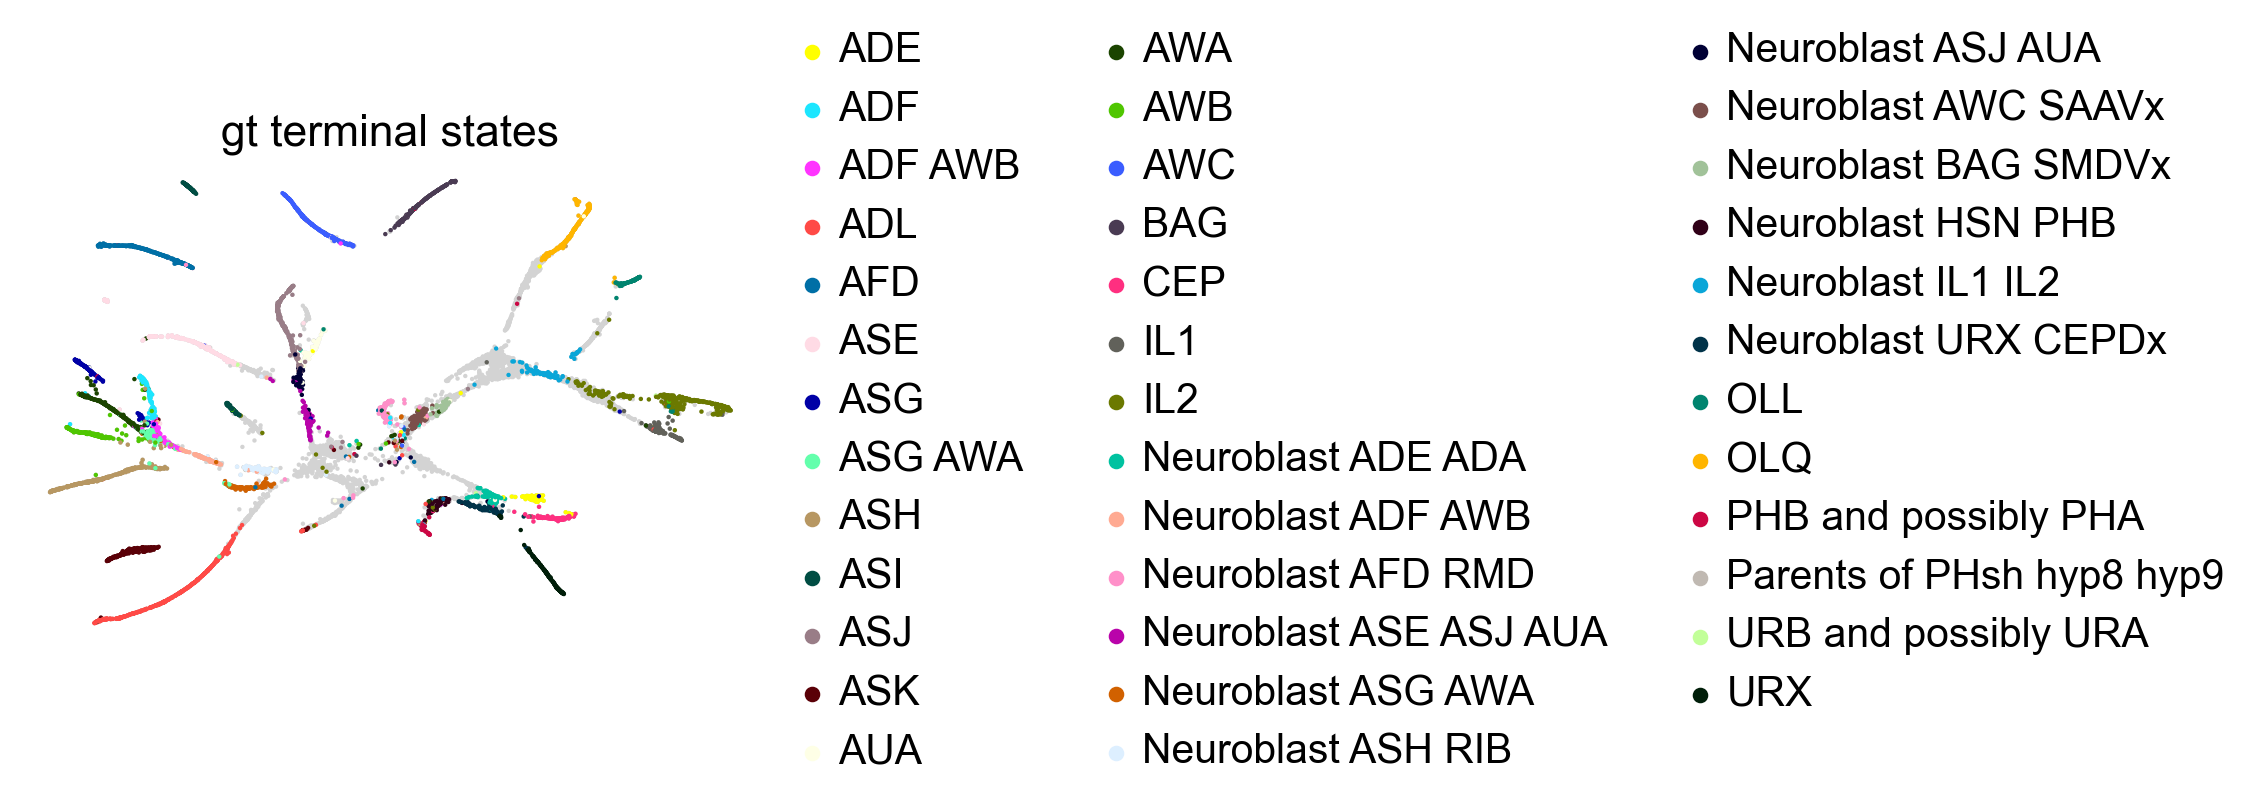

In [21]:
scv.pl.scatter(adata, c=['gt_terminal_states'], basis='ct',
               legend_loc='right')

the obs value 'Phenotype' has more than 103 categories. Uniform 'grey' color will be used for all categories.


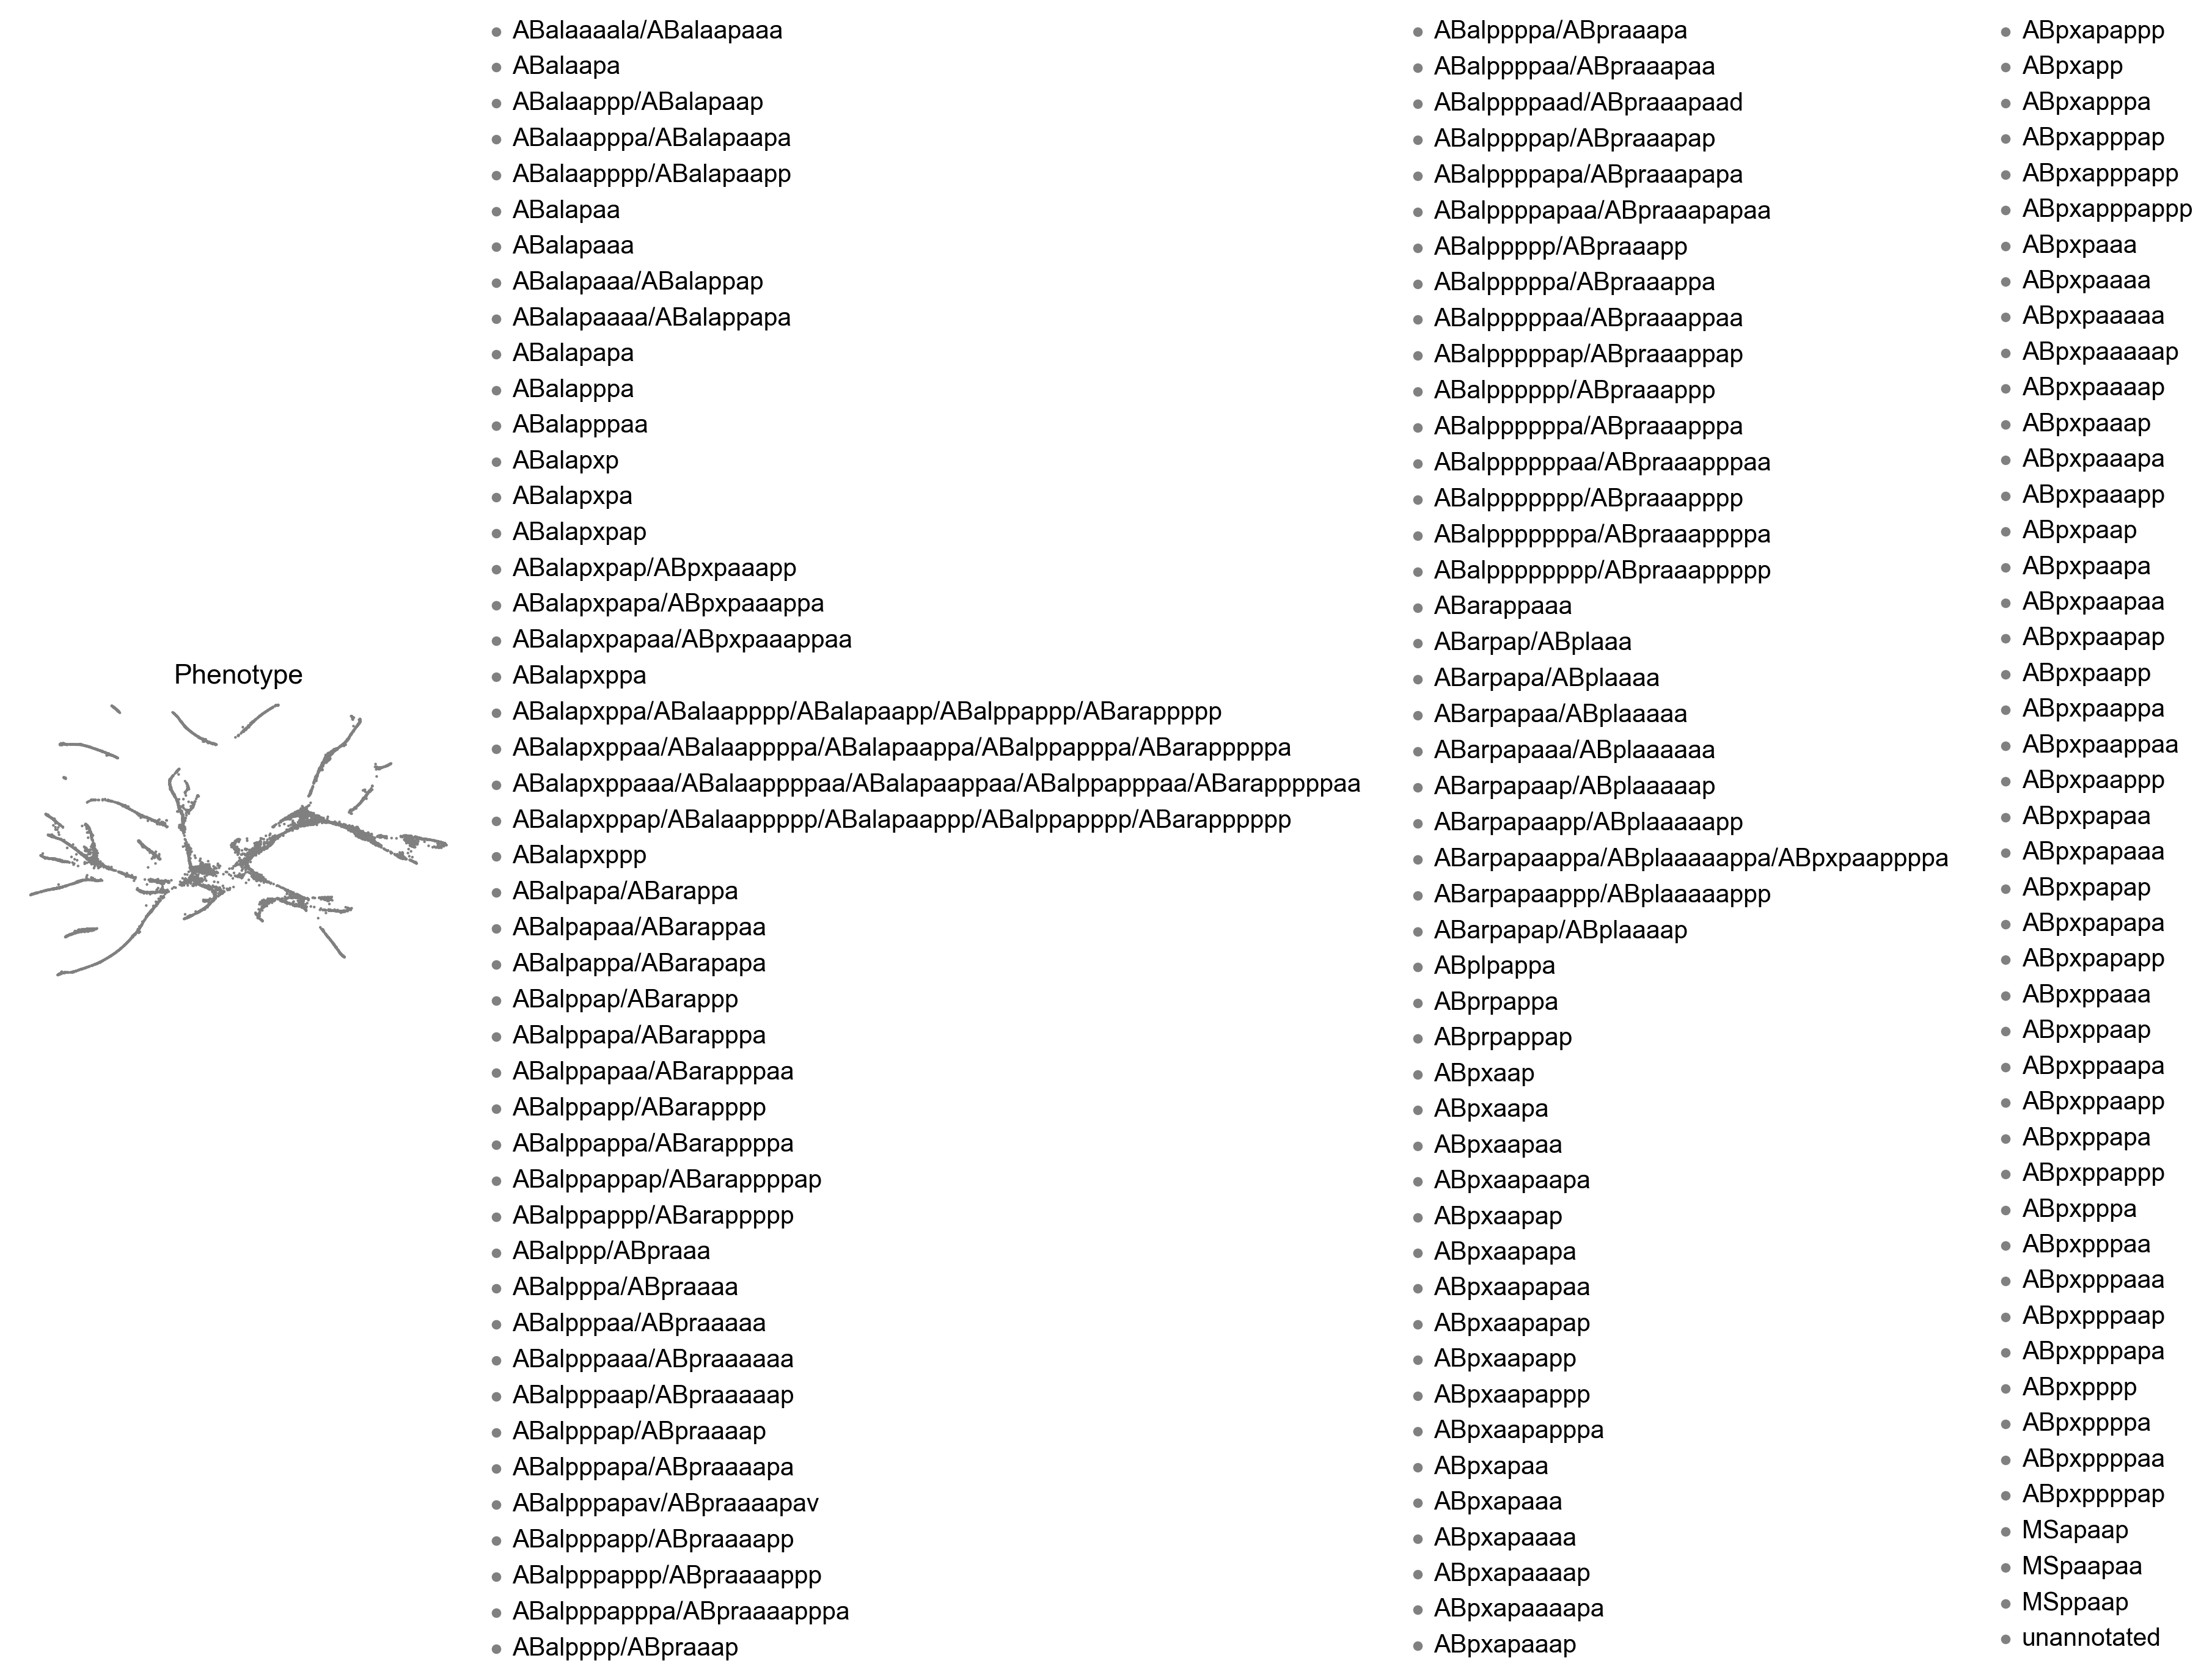

In [22]:
scv.pl.scatter(adata, c=['Phenotype'], basis='ct',
               legend_loc='right')

How many district cell types are there?

In [23]:
len(adata.obs['Phenotype'].cat.categories)

138

In total, there are 502 in the original dataset. 

/Users/marius/Projects/scvelo/scvelo/plotting/utils.py:967: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


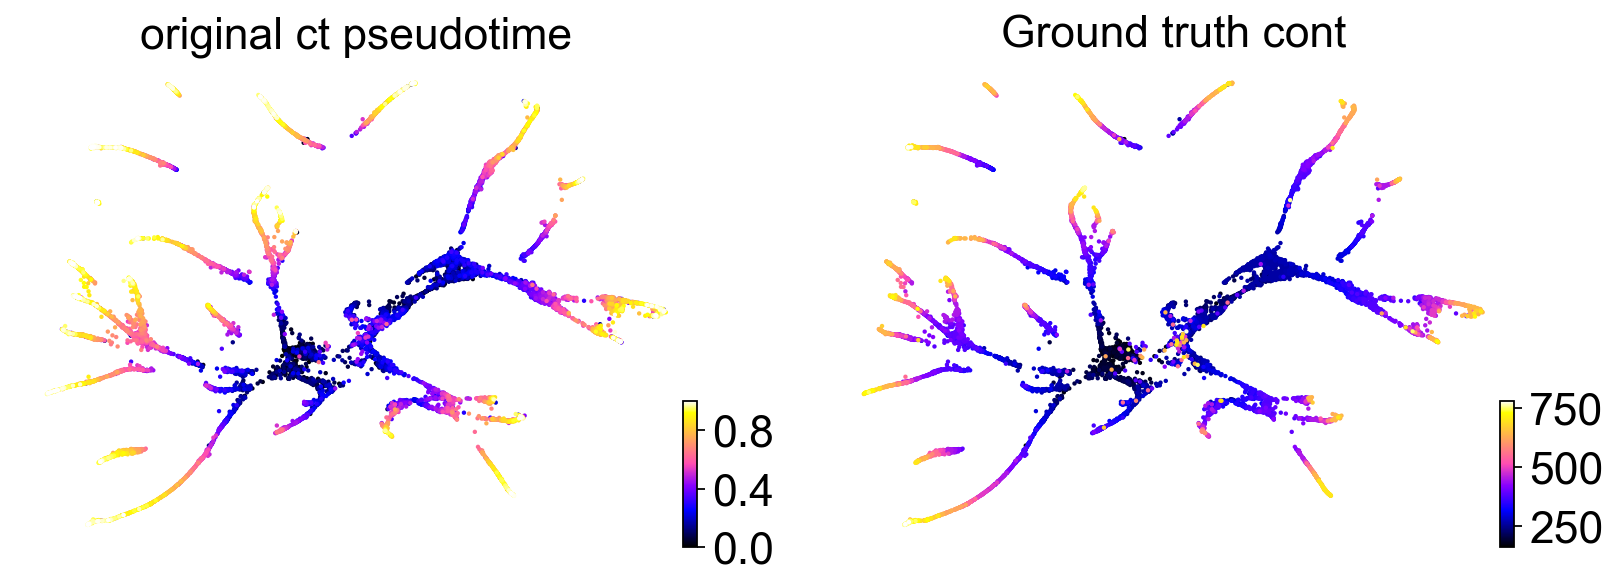

In [24]:
scv.pl.scatter(adata, c=['original_ct_pseudotime', 'Ground_truth_cont'], basis='ct', color_map='gnuplot2',
               legend_loc='right')

/Users/marius/Projects/scvelo/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


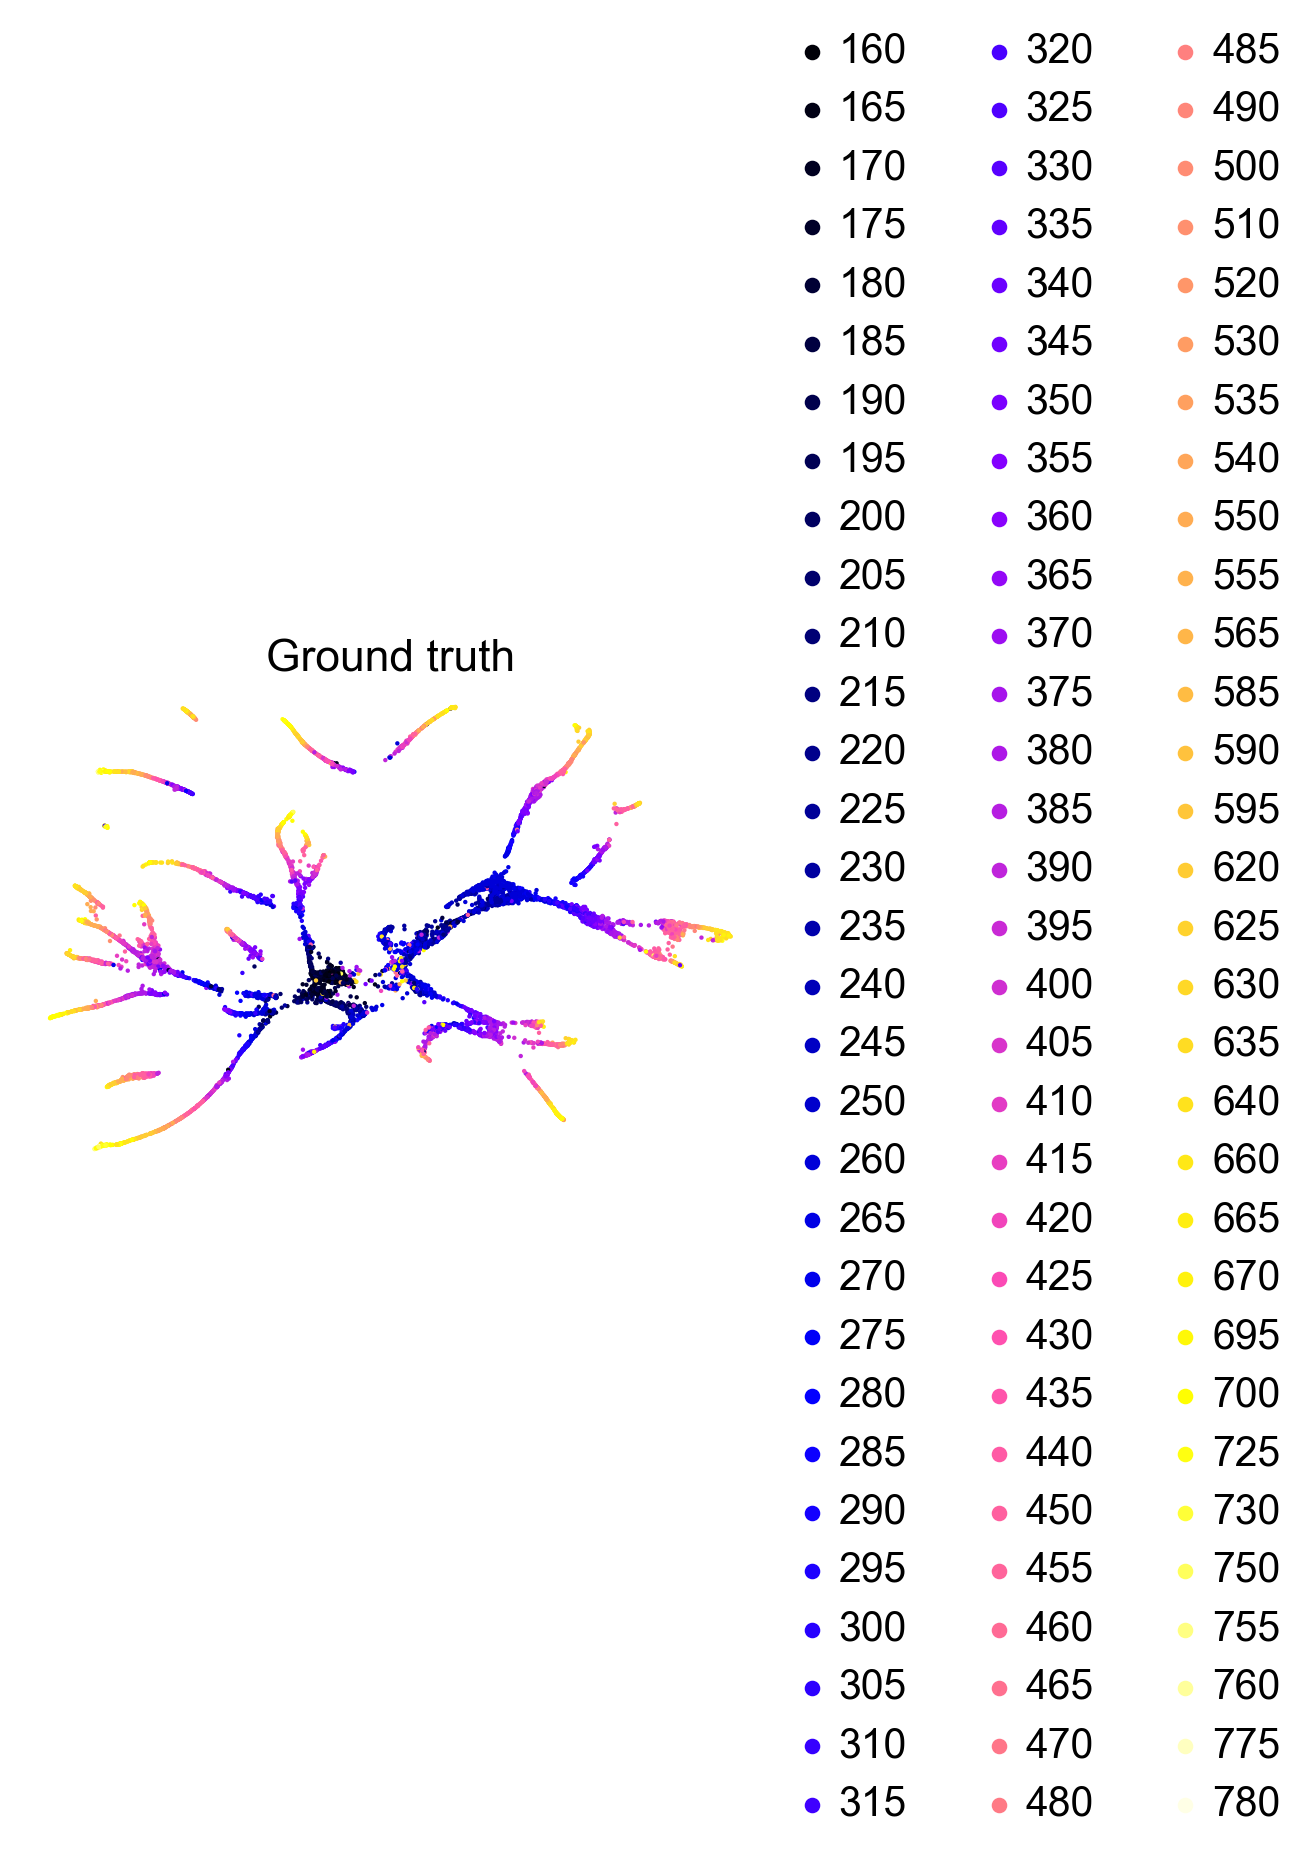

In [25]:
scv.pl.scatter(adata, c=['Ground_truth'], basis='ct', color_map='gnuplot2',
               legend_loc='right')

Note that this isn't the physical time that embryos were isolated at - it's a time estimated from comparing samples with a second time-series experiment. 

/Users/marius/Projects/scvelo/scvelo/plotting/utils.py:967: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


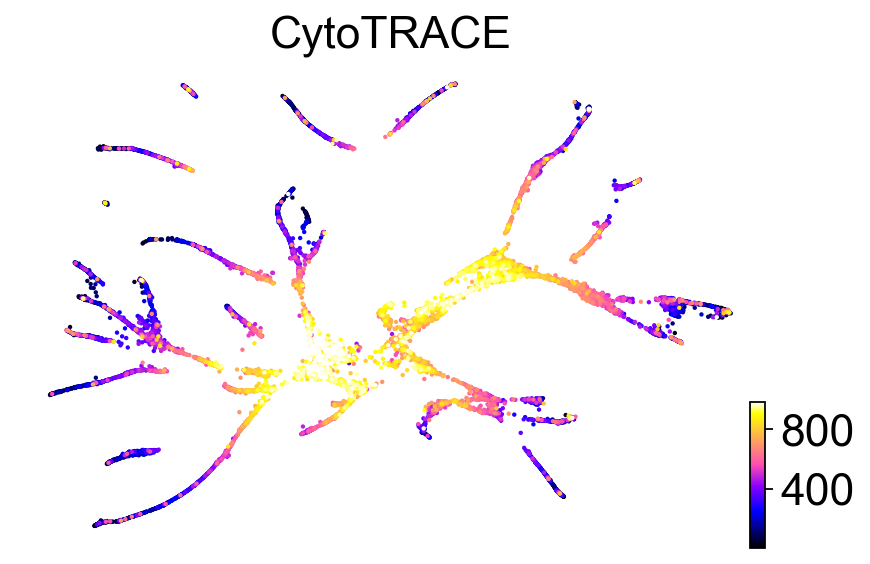

In [26]:
scv.pl.scatter(adata, c=['CytoTRACE'], basis='ct', color_map='gnuplot2',
               legend_loc='right')

## Write data to file

Write the final AnnData object to file for faster loading in the future. 

In [27]:
adata.write(DATA_DIR / "c_elegans" / "ML-2023-07-17_ciliated_neurons_merged.h5ad", compression="gzip")